#**Actividad 6**
**Pronostico de serie de tiempo**

1.- Estacionaridad

Este concepto es importante en la teoría de Análisis de Series de Tiempo. Para aplicar un modelo, se requiere determinar si la serie de tiempo es estacionaria, es decir que sus propiedades estadísticas (promedio, varianza, covarianza)  permanezcan constantes en el tiempo.

**Actividad 1**

Tomar una serie de datos en un periodo sin huecos $(T_{Max}, T_{min})$ de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una.

In [1]:
#Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
#Lineas adicionales 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Tomar la dirección URL del archivo en formato 'raw'
url= 'https://raw.githubusercontent.com/Ferlinn95/Computacional-I/master/Actividad%201/Climatologia%20Diaria%20Merida%20Centro.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'TMax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'TMax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()


# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13903 entries, 1961-01-02 to 2000-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  13883 non-null  float64
 1   Evap    12439 non-null  float64
 2   TMax    13872 non-null  float64
 3   Tmin    13901 non-null  float64
 4   Año     13903 non-null  int64  
 5   Mes     13903 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 760.3+ KB


In [3]:
# Seleccionaremos un conjunto de años de 27 años
df_20 = df_meteo_ts[(df_meteo_ts['Año'] >= 1961) & (df_meteo_ts['Año'] < 1980)]
df_40 = df_meteo_ts[(df_meteo_ts['Año'] >= 1980) & (df_meteo_ts['Año'] < 2000)]

In [4]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
# haciendo una copia de la epoca de 1977 a 2004

# Fechas de inicio y fin, para filtrar la información
start, end = '1985-01', '1993-12'

ts_40 = df_40.loc[start:end].copy()
ts_40.head()

,Precip,Evap,TMax,Tmin,Año,Mes
Fecha,,,,,,
1985-01-01,0.0,5.4,34.5,19.2,1985,Jan
1985-01-02,0.0,9.2,33.1,19.0,1985,Jan
1985-01-03,7.0,1.5,26.4,19.5,1985,Jan
1985-01-04,0.0,3.5,25.5,17.8,1985,Jan
1985-01-05,0.0,3.5,25.0,13.0,1985,Jan


In [6]:
#veamos su encabezado
ts_40['TMax'].head()

Fecha
1985-01-01    34.5
1985-01-02    33.1
1985-01-03    26.4
1985-01-04    25.5
1985-01-05    25.0
Name: TMax, dtype: float64

In [7]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_test_TMax = ts_40['TMax'].copy()

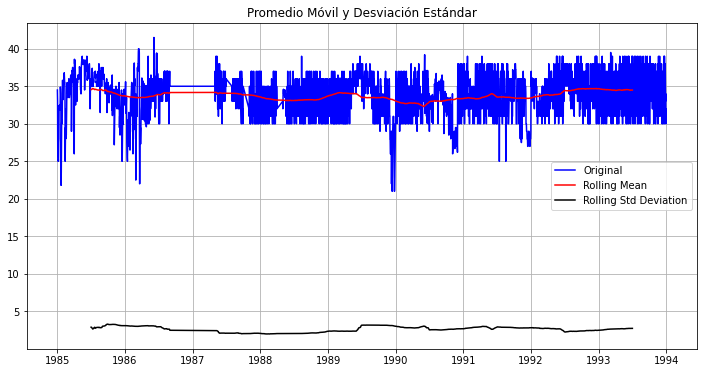

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    2951.000000
Critical Value (1%)              -3.432568
Critical Value (5%)              -2.862520
Critical Value (10%)             -2.567292
dtype: float64


In [8]:
# Realizamos la Prueba de Estacionaridad de TMax
test_stationarity(ts_test_TMax)

#**NOTA**
Tuve que recortar demaciado mis datos ya que tienen muchos datos faltantes 

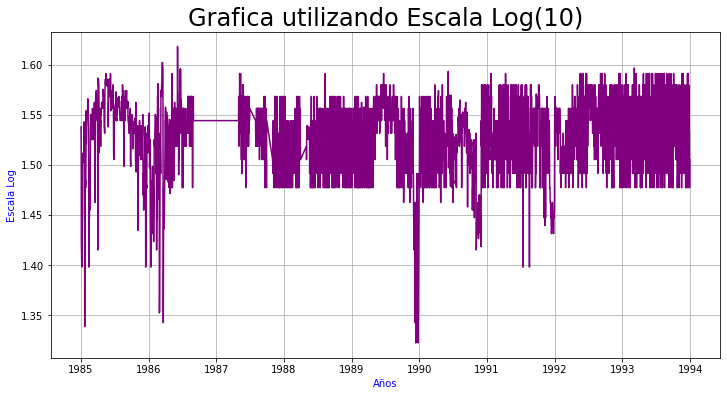

In [9]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMax_log = np.log10(ts_test_TMax)
plt.plot(ts_test_TMax_log, color ="purple")
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Grafica utilizando Escala Log(10)',size=24)
plt.grid()
plt.show();

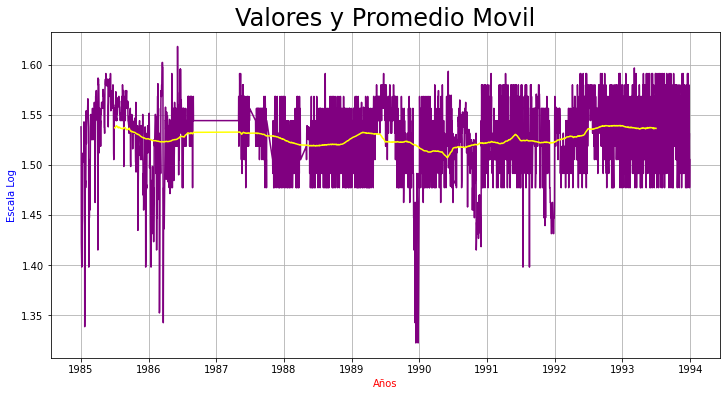

In [10]:
moving_avg_TMax = ts_test_TMax_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMax_log, color= "purple")
plt.plot(moving_avg_TMax, color = 'yellow')
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Movil', size=24)
plt.grid()
plt.show();

In [11]:
ts_test_log_moving_ave_diff_TMax = ts_test_TMax_log - moving_avg_TMax 
ts_test_log_moving_ave_diff_TMax.head()

Fecha
1985-01-01   NaN
1985-01-02   NaN
1985-01-03   NaN
1985-01-04   NaN
1985-01-05   NaN
Name: TMax, dtype: float64

In [12]:
ts_test_log_moving_ave_diff_TMax.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMax.head()

Fecha
1985-07-02    0.009679
1985-07-03    0.007215
1985-07-04    0.018206
1985-07-05    0.016659
1985-07-06    0.022286
Name: TMax, dtype: float64

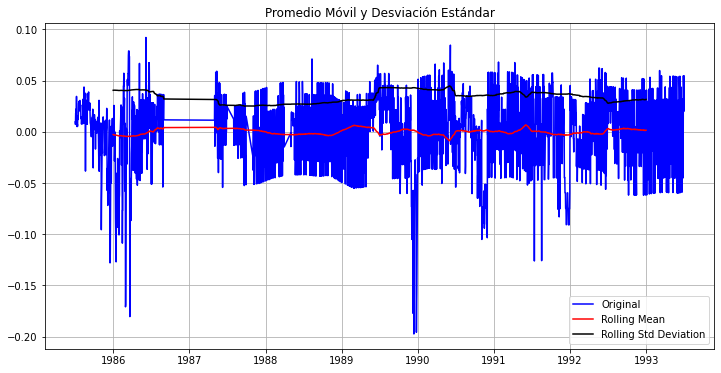

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.677811e+00
p-value                        4.419468e-09
#Lags Used                     2.000000e+01
Number of Observations Used    2.566000e+03
Critical Value (1%)           -3.432901e+00
Critical Value (5%)           -2.862667e+00
Critical Value (10%)          -2.567370e+00
dtype: float64


In [13]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
#calculamos la estacionaiedad de esa dif
test_stationarity(ts_test_log_moving_ave_diff_TMax)

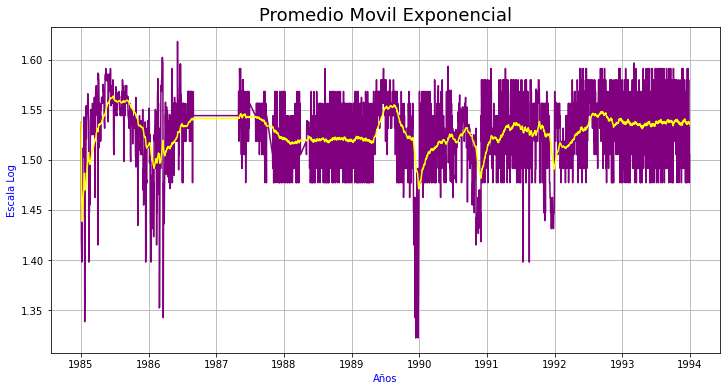

In [14]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMax = ts_test_TMax_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMax_log, color="purple")
plt.plot(EWM_avg_TMax, color = 'yellow')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Movil Exponencial', size=18)
plt.grid()
plt.show();

In [15]:
EWM_avg_TMax.head()

Fecha
1985-01-01    1.537819
1985-01-02    1.528720
1985-01-03    1.492186
1985-01-04    1.470027
1985-01-05    1.454936
Name: TMax, dtype: float64

In [16]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMax = ts_test_TMax_log - EWM_avg_TMax

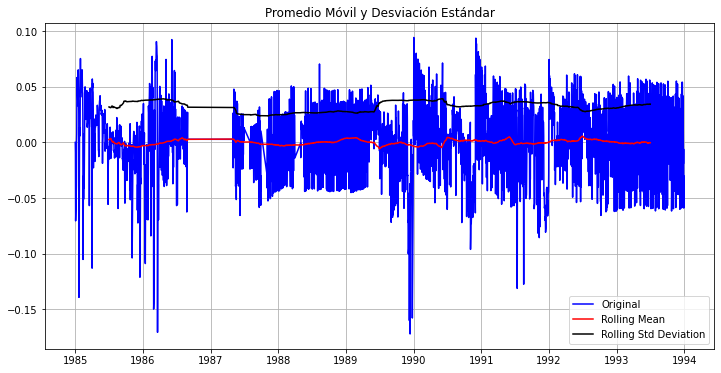

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    2951.000000
Critical Value (1%)              -3.432568
Critical Value (5%)              -2.862520
Critical Value (10%)             -2.567292
dtype: float64


In [17]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMax)

Ahora ya vemosque el valor de p ya es menos que 0.05 por lo tanto podemos rechazar la hipoesis nula de la serie de que la serie de teiempo  no era estacionaria. Por lo tanto afirma que la seie de tiempo es estacionaria. 

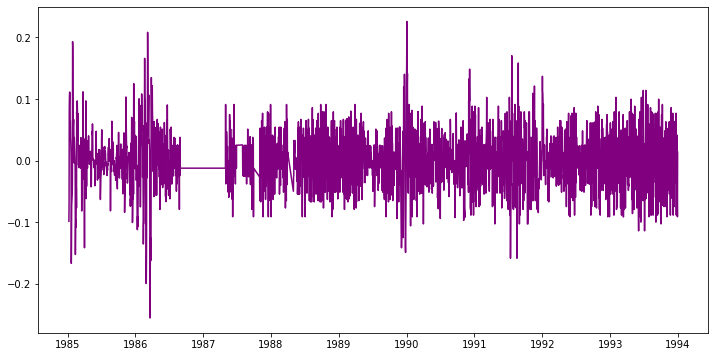

In [18]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_TMax_log - ts_test_TMax_log.shift(periods=7)
plt.plot(ts_test_log_diff,color="purple");

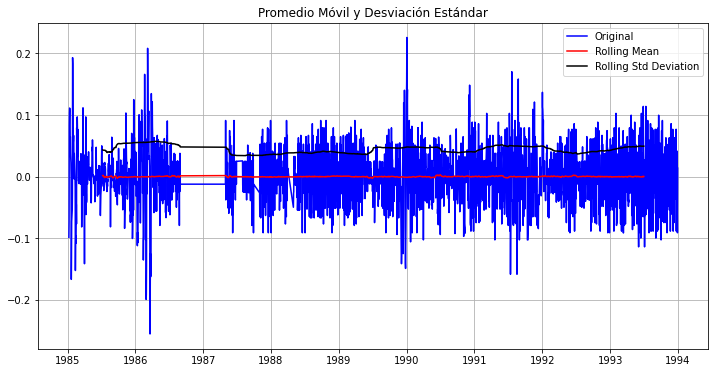

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.380051e+01
p-value                        8.589174e-26
#Lags Used                     2.800000e+01
Number of Observations Used    2.915000e+03
Critical Value (1%)           -3.432595e+00
Critical Value (5%)           -2.862532e+00
Critical Value (10%)          -2.567298e+00
dtype: float64


In [19]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [20]:
# Calculamos el número de datos utilizados
len(ts_test_log_diff)


2944

**TEMPERATURA MAXIMA**

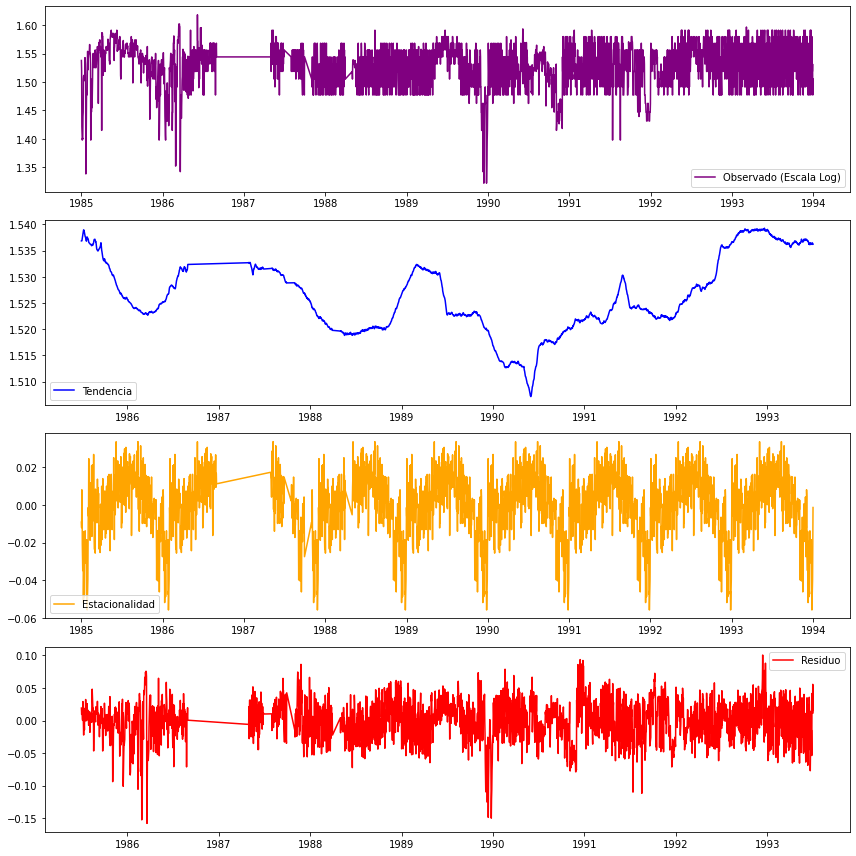

In [21]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_TMax_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMax_log, label='Observado (Escala Log)', color='purple')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='orange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='red')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

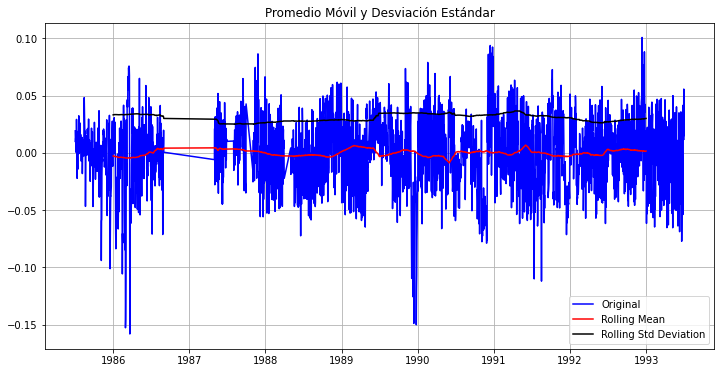

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.100711e+00
p-value                        3.612115e-15
#Lags Used                     1.300000e+01
Number of Observations Used    2.574000e+03
Critical Value (1%)           -3.432893e+00
Critical Value (5%)           -2.862664e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [22]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_TMax_log_decompose = residue 
ts_test_TMax_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_TMax_log_decompose)

#**Tempertura minima**

In [23]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico
ts_test_Tmin = ts_40['Tmin'].copy()

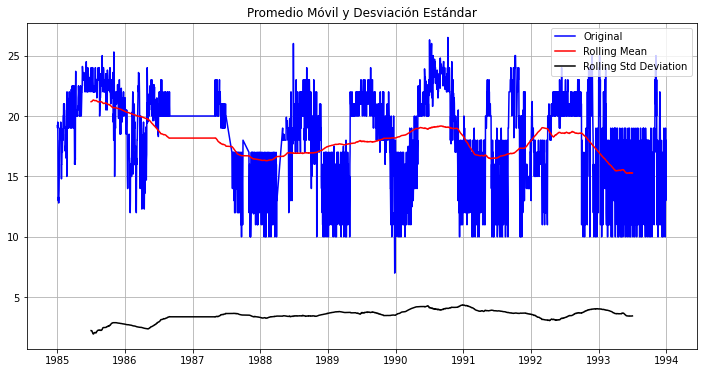

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.087138
p-value                           0.001017
#Lags Used                       24.000000
Number of Observations Used    2927.000000
Critical Value (1%)              -3.432586
Critical Value (5%)              -2.862528
Critical Value (10%)             -2.567296
dtype: float64


In [24]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test_Tmin)

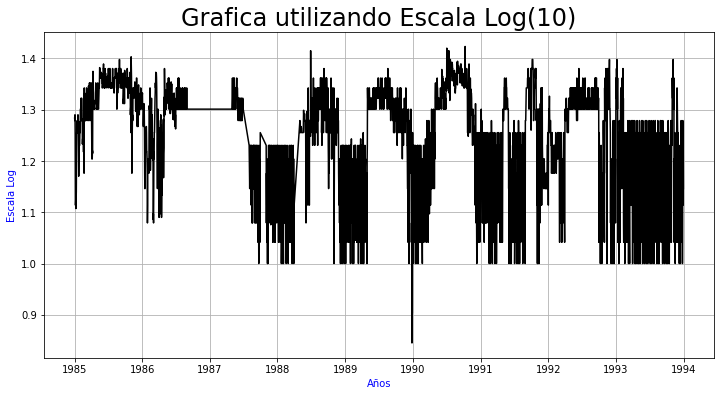

In [25]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_Tmin_log = np.log10(ts_test_Tmin)
plt.plot(ts_test_Tmin_log, color ="black")
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Grafica utilizando Escala Log(10)',size=24)
plt.grid()
plt.show();

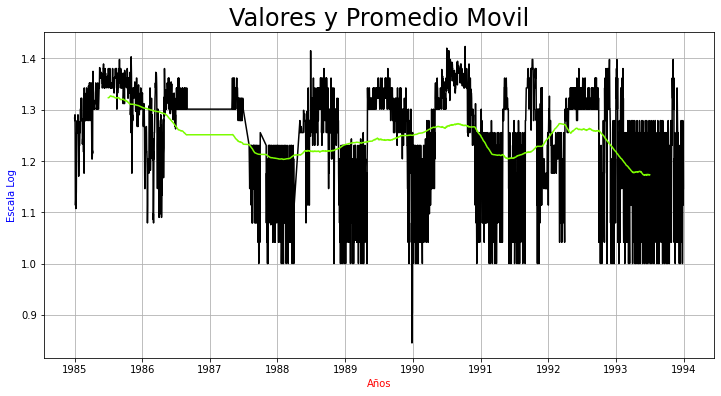

In [26]:
moving_avg_Tmin = ts_test_Tmin_log.rolling(365, center=True).mean()
plt.plot(ts_test_Tmin_log, color= "black")
plt.plot(moving_avg_Tmin, color = 'lawngreen')
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Movil', size=24)
plt.grid()
plt.show();

In [27]:
ts_test_log_moving_ave_diff_Tmin = ts_test_Tmin_log - moving_avg_Tmin
ts_test_log_moving_ave_diff_Tmin.head()

Fecha
1985-01-01   NaN
1985-01-02   NaN
1985-01-03   NaN
1985-01-04   NaN
1985-01-05   NaN
Name: Tmin, dtype: float64

In [28]:
ts_test_log_moving_ave_diff_Tmin.dropna(inplace=True)
ts_test_log_moving_ave_diff_Tmin.head()

Fecha
1985-07-02    0.056909
1985-07-03    0.042063
1985-07-04    0.047495
1985-07-05    0.038125
1985-07-06    0.047297
Name: Tmin, dtype: float64

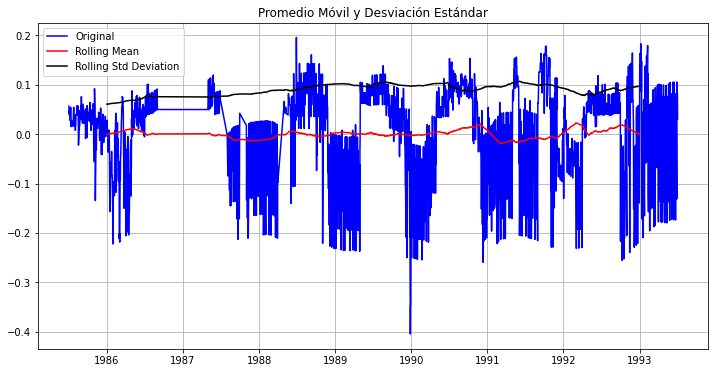

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -5.995645e+00
p-value                        1.704206e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.578000e+03
Critical Value (1%)           -3.432889e+00
Critical Value (5%)           -2.862662e+00
Critical Value (10%)          -2.567367e+00
dtype: float64


In [29]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
#calculamos la estacionaiedad de esa dif
test_stationarity(ts_test_log_moving_ave_diff_Tmin)

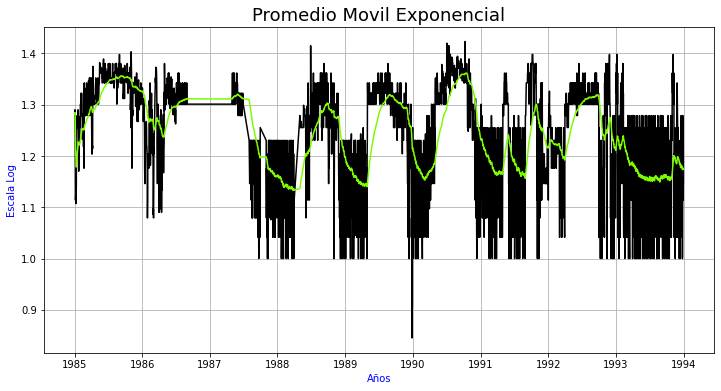

In [30]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_Tmin = ts_test_Tmin_log.ewm(halflife=30).mean()
plt.plot(ts_test_Tmin_log, color="black")
plt.plot(EWM_avg_Tmin, color = 'lawngreen')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Movil Exponencial', size=18)
plt.grid()
plt.show();

In [31]:
EWM_avg_Tmin.head()

Fecha
1985-01-01    1.283301
1985-01-02    1.281001
1985-01-03    1.284082
1985-01-04    1.275373
1985-01-05    1.241578
Name: Tmin, dtype: float64

In [32]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_Tmin = ts_test_Tmin_log - EWM_avg_Tmin

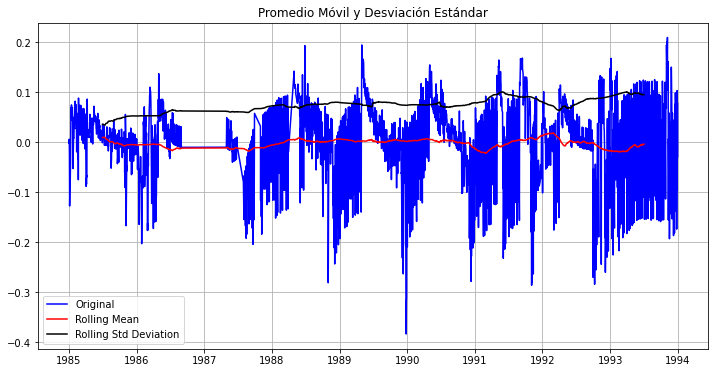

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.746857e+00
p-value                        2.906987e-14
#Lags Used                     9.000000e+00
Number of Observations Used    2.942000e+03
Critical Value (1%)           -3.432575e+00
Critical Value (5%)           -2.862523e+00
Critical Value (10%)          -2.567293e+00
dtype: float64


In [33]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_Tmin)

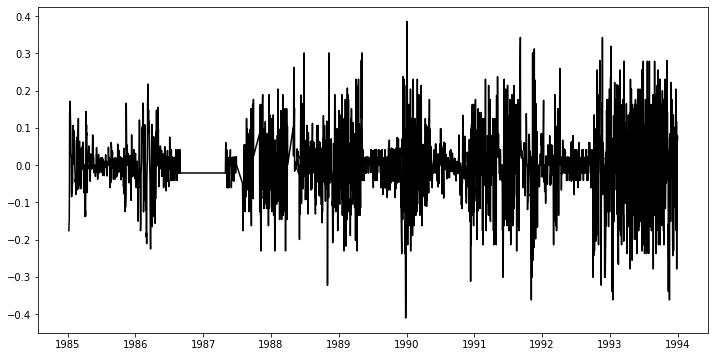

In [34]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_2 = ts_test_Tmin_log - ts_test_Tmin_log.shift(periods=7)
plt.plot(ts_test_log_diff_2,color="black");

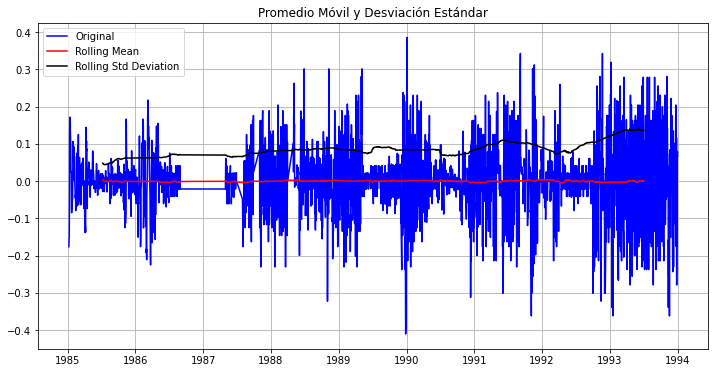

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.254692e+01
p-value                        2.249804e-23
#Lags Used                     2.800000e+01
Number of Observations Used    2.916000e+03
Critical Value (1%)           -3.432595e+00
Critical Value (5%)           -2.862532e+00
Critical Value (10%)          -2.567298e+00
dtype: float64


In [35]:
# Probamos la estacionaridad
ts_test_log_diff_2.dropna(inplace=True)
test_stationarity(ts_test_log_diff_2)

In [36]:
# Calculamos el número de datos utilizados
len(ts_test_log_diff_2)

2945

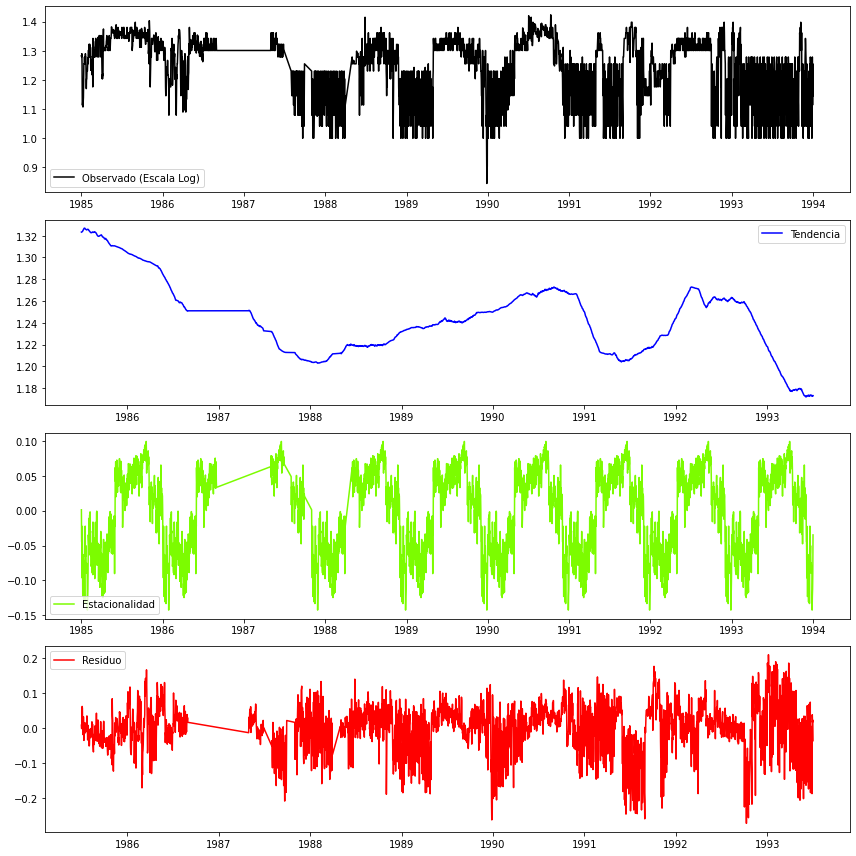

In [37]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_Tmin_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_Tmin_log, label='Observado (Escala Log)', color='black')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='lawngreen')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='red')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

#**Actividad 2**
Construye los modelos ARIMA para cada Temperatura $(T_{Max}$ y $T_{min})$, y contrasta la bondad del ajuste en cada caso, calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo gráficamente ambas series, la observada y la construida con el **método ARIMA**. 

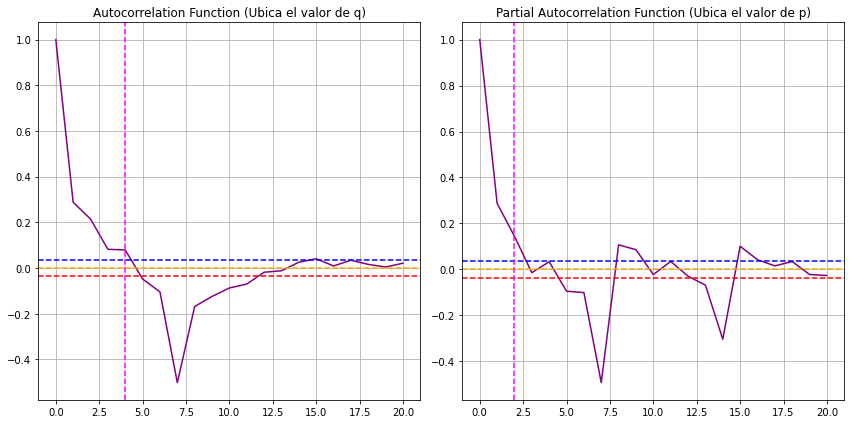

In [38]:
 #Aplicamos el modelo de ARIMA en la TMax 

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='purple')
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='blue')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='magenta')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='purple')
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='blue')

# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='magenta')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

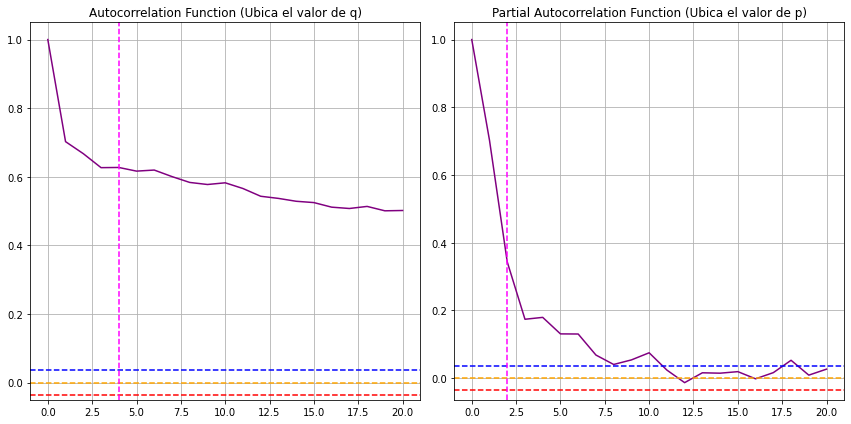

In [39]:
 #Aplicamos el modelo de ARIMA en la Tmin 

lag_acf = acf(ts_test_Tmin_log, nlags=20)
lag_pacf = pacf(ts_test_Tmin_log, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='purple')
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_Tmin_log)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_Tmin_log)), linestyle='--', color='blue')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='magenta')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='purple')
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_Tmin_log)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_Tmin_log)), linestyle='--', color='blue')

# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='magenta')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

#**Modelo AR (Auto-Regresion)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                 2943
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4795.700
Method:                       css-mle   S.D. of innovations              0.047
Date:                Thu, 01 Apr 2021   AIC                          -9583.401
Time:                        16:25:58   BIC                          -9559.452
Sample:                             1   HQIC                         -9574.778
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.444e-05      0.001      0.029      0.977      -0.001       0.001
ar.L1.D.TMax    -0.5389      0.018    -29.796      0.000      -0.574      -0.503
ar.L2.D.TMax    -0.1990      0.018    -10.99

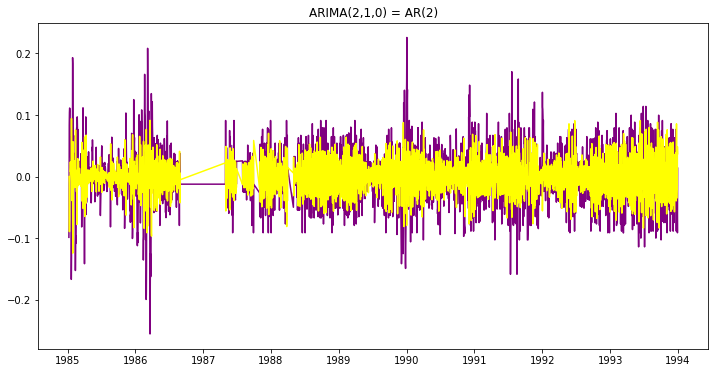

In [40]:
# Modelo AR(p): (p,d,q) = (2,1,0)  en la TMax
model = ARIMA(ts_test_log_diff, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='purple')
plt.plot(results_AR.fittedvalues, color='yellow')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2951
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3755.251
Method:                       css-mle   S.D. of innovations              0.068
Date:                Thu, 01 Apr 2021   AIC                          -7502.501
Time:                        16:25:58   BIC                          -7478.542
Sample:                             1   HQIC                         -7493.876
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.643e-05      0.001     -0.052      0.959      -0.001       0.001
ar.L1.D.Tmin    -0.5423      0.018    -30.273      0.000      -0.577      -0.507
ar.L2.D.Tmin    -0.2300      0.018    -12.83

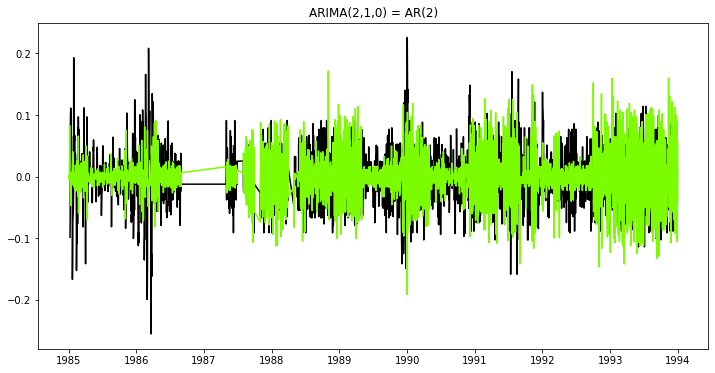

In [41]:
# Modelo AR(p): (p,d,q) = (2,1,0) en la Tmin
model = ARIMA(ts_test_Tmin_log, order=(2,1,0), missing='drop')
results_AR_2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='black')
plt.plot(results_AR_2.fittedvalues, color='lawngreen')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_2.summary())

#**Modelo MA (Promedio Movil)**

In [44]:
# Modelo MA(q): (p,d,q) = (0,1,4) en la TMax
Modelo = ARIMA(ts_test_TMax_log, order=(0,1,4), missing='drop')
results_MA = Modelo.fit(displ=1)
plt.plot(ts_test_log_diff,color="purple")
plt.plot(results_MA.fittedvalues, color='yellow')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) en la Tmin 
model = ARIMA(ts_test_Tmin_log, order=(0,1,4), missing='drop')
results_MA_2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff,color="black")
plt.plot(results_MA_2.fittedvalues, color='lawngreen')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA_2.summary())

#**Modelo ARIMA (Auto- Regresion + Promedio  Movil)**

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) en TMax
model = ARIMA(ts_test_TMax_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff,color="purple")
plt.plot(results_ARIMA.fittedvalues, color='yellow')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) de Tmin
model = ARIMA(ts_test_Tmin_log, order=(2,1,4), missing='drop')
results_ARIMA_2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff,color="black")
plt.plot(results_ARIMA_2.fittedvalues, color='lawngreen')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA_2.summary())